In [104]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mle-ese-mock/train (5).csv
/kaggle/input/mle-ese-mock/submission (6).csv
/kaggle/input/mle-ese-mock/test (4).csv


0:	learn: 2.3615479	test: 2.3636721	best: 2.3636721 (0)	total: 38ms	remaining: 37.9s
100:	learn: 1.3305972	test: 1.4184082	best: 1.4184082 (100)	total: 3.58s	remaining: 31.8s
200:	learn: 1.1520863	test: 1.3072043	best: 1.3072043 (200)	total: 6.97s	remaining: 27.7s
300:	learn: 1.0156758	test: 1.2493153	best: 1.2493153 (300)	total: 10.7s	remaining: 24.8s
400:	learn: 0.8985051	test: 1.2089942	best: 1.2089942 (400)	total: 14.4s	remaining: 21.5s
500:	learn: 0.8123402	test: 1.1942947	best: 1.1940792 (499)	total: 18.1s	remaining: 18.1s
600:	learn: 0.7379895	test: 1.1844928	best: 1.1843860 (599)	total: 21.9s	remaining: 14.5s
700:	learn: 0.6775993	test: 1.1814170	best: 1.1814170 (700)	total: 25.6s	remaining: 10.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.180352689
bestIteration = 711

Shrink model to first 712 iterations.
Validation Accuracy: 0.4622
Validation Log Loss: 1.1804
Submission saved as submission_catboost_simple.csv


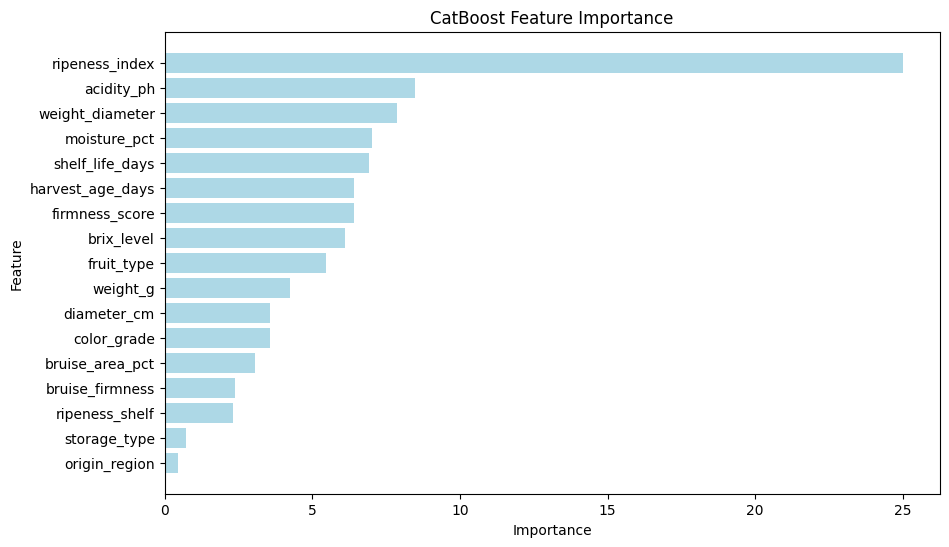

In [105]:
# -------------------------
# Simple CatBoost Pipeline for MLE-ESE-MOCK
# -------------------------

# Step 1: Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt

# Step 2: Load Data
train = pd.read_csv("/kaggle/input/mle-ese-mock/train (5).csv")
test = pd.read_csv("/kaggle/input/mle-ese-mock/test (4).csv")
submission = pd.read_csv("/kaggle/input/mle-ese-mock/submission (6).csv")

# Step 3: Features
categorical_features = ['fruit_type', 'color_grade', 'storage_type', 'origin_region']
numerical_features = ['weight_g', 'diameter_cm', 'firmness_score', 'brix_level', 
                      'acidity_ph', 'ripeness_index', 'bruise_area_pct', 
                      'moisture_pct', 'shelf_life_days', 'harvest_age_days']
target = 'quality_grade'

# Step 4: Encode Target
le_target = LabelEncoder()
train[target] = le_target.fit_transform(train[target])
num_classes = len(le_target.classes_)

# Step 5: Feature Engineering
train['weight_diameter'] = train['weight_g'] * train['diameter_cm']
test['weight_diameter'] = test['weight_g'] * test['diameter_cm']

train['ripeness_shelf'] = train['ripeness_index'] / (train['shelf_life_days'] + 1)
test['ripeness_shelf'] = test['ripeness_index'] / (test['shelf_life_days'] + 1)

train['bruise_firmness'] = train['bruise_area_pct'] * train['firmness_score']
test['bruise_firmness'] = test['bruise_area_pct'] * test['firmness_score']

numerical_features += ['weight_diameter', 'ripeness_shelf', 'bruise_firmness']

# Step 6: Train/Validation Split
X = train[categorical_features + numerical_features]
y = train[target]
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 7: CatBoost Model
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    loss_function='MultiClass',
    eval_metric='MultiClass',
    cat_features=categorical_features,
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100
)

model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val)
)

# Step 8: Validation Metrics
val_preds = model.predict_proba(X_val)
val_pred_labels = np.argmax(val_preds, axis=1)

accuracy = accuracy_score(y_val, val_pred_labels)
val_logloss = log_loss(y_val, val_preds)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Log Loss: {val_logloss:.4f}")

# Step 9: Predict Test Data
X_test = test[categorical_features + numerical_features]
test_preds = model.predict_proba(X_test)

# Step 10: Prepare Submission
target_cols = submission.columns[1:]
test_preds = test_preds[:, :len(target_cols)]  # ensure shape matches
submission_df = pd.DataFrame(test_preds, columns=target_cols)
submission_df.insert(0, 'id', submission['id'])
submission_df.to_csv("submission_catboost_simple.csv", index=False)
print("Submission saved as submission_catboost_simple.csv")

# Step 11: Feature Importance
feat_imp = model.get_feature_importance()
feat_names = categorical_features + numerical_features

feat_imp_df = pd.DataFrame({
    'Feature': feat_names,
    'Importance': feat_imp
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='lightblue')
plt.gca().invert_yaxis()
plt.title("CatBoost Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [2]:
# MultiColumn (0.6 log loss-Nitish)

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, log_loss

# ======================
# LOAD DATA
# ======================
train = pd.read_csv("/kaggle/input/mle-ese-mock/train (5).csv")
test  = pd.read_csv("/kaggle/input/mle-ese-mock/test (4).csv")

# ======================
# TARGET CLEANING
# ======================
y = train["quality_grade"].replace(r'^\s*$', np.nan, regex=True)
mask = y.notna()

X = train.loc[mask].drop(columns=["quality_grade"])
y = y.loc[mask]

# ======================
# DROP ID
# ======================
test_id = test["id"]
X = X.drop(columns=["id"], errors="ignore")
test = test.drop(columns=["id"], errors="ignore")

# ======================
# HANDLE MISSING VALUES
# ======================
X = X.fillna(X.mean(numeric_only=True)).fillna(X.mode().iloc[0])
test = test.fillna(test.mean(numeric_only=True)).fillna(test.mode().iloc[0])

# ❌ OUTLIER HANDLING REMOVED (RF doesn't need it)

# ======================
# FEATURE TYPES
# ======================
cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(include="number").columns

# ======================
# PREPROCESSOR
# ======================
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols)
])

# ======================
# TRAIN / VALIDATION SPLIT
# ======================
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# ======================
# PIPELINE (AGGRESSIVE RF)
# ======================
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=800,        # 🔥 more trees
        max_depth=20,            # 🔥 deeper trees
        min_samples_split=2,
        min_samples_leaf=1,
        max_features="sqrt",
        class_weight=None,       # 🔥 accuracy boost
        random_state=42
    ))
])

# ======================
# GRID SEARCH (ACCURACY-FOCUSED)
# ======================
param_grid = {
    "classifier__n_estimators": [500, 800],
    "classifier__max_depth": [15, 20, None]
}

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=3,
    scoring="accuracy",   # 🔥 focus on accuracy
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print("Best Params:", grid.best_params_)

# ======================
# VALIDATION METRICS
# ======================
y_val_pred  = best_model.predict(X_val)
y_val_proba = best_model.predict_proba(X_val)

print("\nValidation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation ROC-AUC:",
      roc_auc_score(y_val, y_val_proba, multi_class="ovr"))

print("Validation Log Loss:",
      log_loss(
          y_val,
          y_val_proba,
          labels=best_model.named_steps["classifier"].classes_
      ))

print("\nClassification Report:\n")
print(classification_report(y_val, y_val_pred))

# ======================
# TRAIN ON FULL DATA
# ======================
best_model.fit(X, y)

# ======================
# TEST PREDICTIONS
# ======================
test_proba = best_model.predict_proba(test)

# ======================
# SUBMISSION
# ======================
submission = pd.DataFrame({"id": test_id})

for i, cls in enumerate(best_model.named_steps["classifier"].classes_):
    submission[f"Status_{cls}"] = test_proba[:, i]
submission.to_csv("submis.csv", index=False)
submission.head()
#Multiclass(Samveg-For TargetNull)


Best Params: {'classifier__max_depth': 15, 'classifier__n_estimators': 800}

Validation Accuracy: 0.453125
Validation ROC-AUC: 0.9070338027909491
Validation Log Loss: 1.2719205183666822

Classification Report:

                  precision    recall  f1-score   support

       Q10_waste       0.65      0.80      0.72        45
Q1_premium_fresh       0.61      0.76      0.67        45
        Q2_fresh       0.43      0.36      0.40        44
 Q3_export_grade       0.47      0.51      0.49        45
      Q4_dessert       0.35      0.39      0.37        44
   Q5_juice_high       0.32      0.29      0.30        45
    Q6_juice_low       0.44      0.44      0.44        45
   Q7_processing       0.35      0.27      0.30        45
   Q8_local_sale       0.38      0.33      0.35        45
         Q9_feed       0.40      0.38      0.39        45

        accuracy                           0.45       448
       macro avg       0.44      0.45      0.44       448
    weighted avg       0.44      

,id,Status_Q10_waste,Status_Q1_premium_fresh,Status_Q2_fresh,Status_Q3_export_grade,Status_Q4_dessert,Status_Q5_juice_high,Status_Q6_juice_low,Status_Q7_processing,Status_Q8_local_sale,Status_Q9_feed
0,0,0.000000,0.038983,0.169817,0.261594,0.357721,0.130647,0.034266,0.002701,0.001771,0.002500
1,1,0.582692,0.000000,0.000000,0.000000,0.000000,0.001250,0.003750,0.022523,0.118474,0.271311
2,2,0.000000,0.633747,0.197745,0.133962,0.026796,0.005250,0.002500,0.000000,0.000000,0.000000
3,3,0.000125,0.042963,0.114953,0.436826,0.231244,0.114050,0.054149,0.004315,0.001250,0.000125
4,4,0.063260,0.000000,0.000000,0.000000,0.003229,0.017798,0.157064,0.275171,0.311785,0.171692
